### Préparation des features pour la modélisation

A réaliser :
* Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation.
* Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.
* Débarrassez-vous des features redondantes en utilisant une matrice de corrélation de Pearson. Pour cela, utiisez la méthode corr() de Pandas, couplé d'un graphique Heatmap de la librairie Seaborn 
* Réalisez différents graphiques pour comprendre le lien entre vos features et la TARGET (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).
*  Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre TARGET).
* Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne. Les deux méthodes d'encodage à connaitre sont le OneHotEncoder et le LabelEncoder

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from category_encoders import BinaryEncoder

import sys
import importlib
sys.path.append("..")
import config
importlib.reload(config)  # Ensure we get the latest TARGET value
from config import TARGET

In [47]:
# Load the dataset

building_consumption = pd.read_csv("../assets/building_consumption_post_feature_engineering.csv")
building_consumption.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,K-12 School,Retail Store,Other,Hospital (General Medical & Surgical),Medical Office,Other - Entertainment/Public Assembly,NumberofFloors_quintile,SteamUse,NaturalGas,Electricity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,0,0,0,0,0,0,4,1,1,1
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,0,0,0,0,0,0,4,0,1,1
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,0,0,0,0,0,0,4,1,1,1
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,0,0,0,0,0,0,4,1,1,1
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,0,0,0,0,0,0,4,0,1,1


#### Matrice de corrélation

TotalGHGEmissions                        1.000000
SiteEnergyUseWN(kBtu)                    0.884307
SiteEnergyUse(kBtu)                      0.881552
Hospital (General Medical & Surgical)    0.678772
Electricity(kWh)                         0.676477
NaturalGas(therms)                       0.601914
NumberofBuildings                        0.539629
PropertyGFABuilding(s)                   0.497541
PropertyGFATotal                         0.458368
GHGEmissionsIntensity                    0.393990
SiteEUI(kBtu/sf)                         0.296863
SiteEUIWN(kBtu/sf)                       0.292710
SteamUse                                 0.259930
SourceEUI(kBtu/sf)                       0.243372
SourceEUIWN(kBtu/sf)                     0.239004
NumberofFloors_quintile                  0.191124
Parking                                  0.115559
NaturalGas                               0.094475
Hotel                                    0.092096
PropertyGFAParking                       0.091454


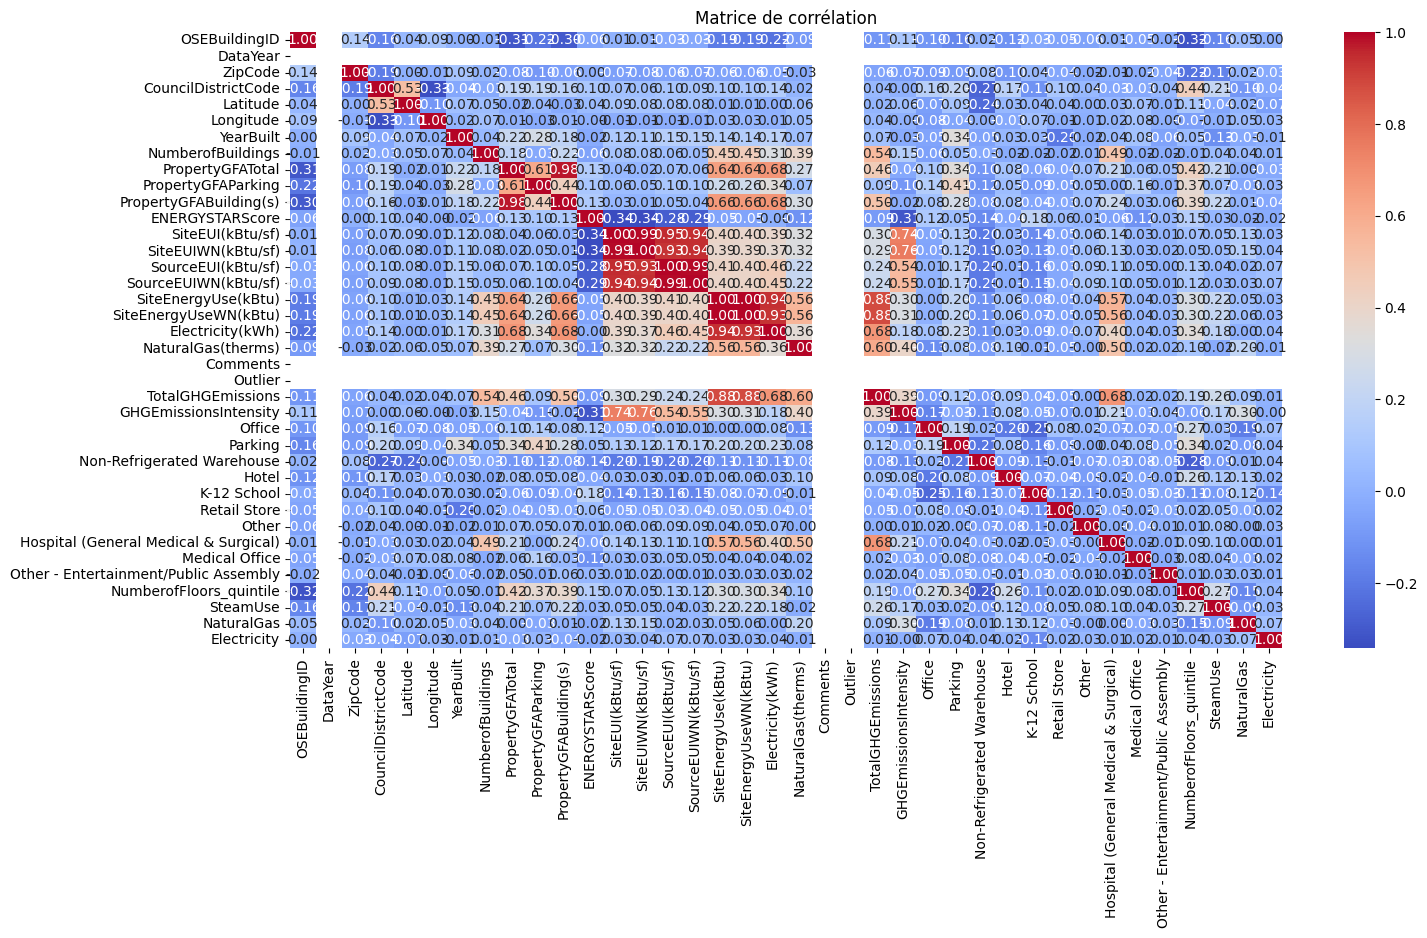

In [48]:
num_cols = building_consumption.select_dtypes(include="number")
corr_matrix = num_cols.corr()
print(corr_matrix[TARGET].sort_values(ascending=False))
plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()

# Une fois la TARGET choisie, quelles features supprimer ?
# Suppression des features très corrélées avec la TARGET (corr > 0.7) ? > 0 A CONFIRMER
# Ne pas garder à la fois PropertyGFABuilding(s), PropertyGFAParking et PropertyGFATotal ? Supprimer Total ?

### Suppression des colonnes

In [49]:
### Suppression des colonnes
cols_to_drop = [
    "OSEBuildingID",
    "Comments",
    "DataYear",
    "TaxParcelIdentificationNumber",
    "State",
    "DefaultData",
    "NaturalGas(therms)",
    "Electricity(kWh)",
    "SiteEUI(kBtu/sf)",
    "SiteEUIWN(kBtu/sf)",
    "SiteEnergyUse(kBtu)",
    "SiteEnergyUseWN(kBtu)",
	"SourceEUI(kBtu/sf)",
    "SourceEUIWN(kBtu/sf)",
    "GHGEmissionsIntensity",
    "ListOfAllPropertyUseTypes",  # Supprimé car trop de modalités différentes, et géré par Feature engineering
    "YearsENERGYSTARCertified",
    "Outlier",
    "City",
    "PropertyName",
    "Address",
    "Neighborhood",  # CouncilDistrict plus précis
    "Longitude",
    "Latitude",
    "ComplianceStatus",
    "ZipCode",
]
existing_cols = [col for col in cols_to_drop if col in building_consumption.columns]
building_consumption.drop(columns=existing_cols, inplace=True)
# building_consumption.columns
num_cols = building_consumption.select_dtypes(include="number")
corr_matrix = num_cols.corr()
print(corr_matrix[TARGET].sort_values(ascending=False))

TotalGHGEmissions                        1.000000
Hospital (General Medical & Surgical)    0.678772
NumberofBuildings                        0.539629
PropertyGFABuilding(s)                   0.497541
PropertyGFATotal                         0.458368
SteamUse                                 0.259930
NumberofFloors_quintile                  0.191124
Parking                                  0.115559
NaturalGas                               0.094475
Hotel                                    0.092096
PropertyGFAParking                       0.091454
YearBuilt                                0.072428
CouncilDistrictCode                      0.038432
Medical Office                           0.021511
Other - Entertainment/Public Assembly    0.019599
Electricity                              0.007946
Other                                    0.003632
K-12 School                             -0.039730
Retail Store                            -0.050591
Non-Refrigerated Warehouse              -0.084996


### Encodage binaire de la feature PrimaryPropertyType

In [50]:
encoder = BinaryEncoder()
primary_property_type_encoded = encoder.fit_transform(
	building_consumption[["PrimaryPropertyType"]]
)
primary_property_type_encoded.shape
building_consumption = pd.concat(
    [building_consumption, primary_property_type_encoded], axis=1  # type: ignore
)
building_consumption.drop(columns=["PrimaryPropertyType"], inplace=True)
building_consumption.head()

,BuildingType,CouncilDistrictCode,YearBuilt,NumberofBuildings,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,TotalGHGEmissions,Office,...,Other - Entertainment/Public Assembly,NumberofFloors_quintile,SteamUse,NaturalGas,Electricity,PrimaryPropertyType_0,PrimaryPropertyType_1,PrimaryPropertyType_2,PrimaryPropertyType_3,PrimaryPropertyType_4
0,NonResidential,7,1927,1.0,88434,0,88434,60.0,249.98,0,...,0,4,1,1,1,0,0,0,0,1
1,NonResidential,7,1996,1.0,103566,15064,88502,61.0,295.86,0,...,0,4,0,1,1,0,0,0,0,1
2,NonResidential,7,1969,1.0,956110,196718,759392,43.0,2089.28,0,...,0,4,1,1,1,0,0,0,0,1
3,NonResidential,7,1926,1.0,61320,0,61320,56.0,286.43,0,...,0,4,1,1,1,0,0,0,0,1
4,NonResidential,7,1980,1.0,175580,62000,113580,75.0,505.01,0,...,0,4,0,1,1,0,0,0,0,1


### One-hot encoding sur BuildingType

In [51]:
building_consumption["BuildingType"].nunique()
building_consumption["BuildingType"].value_counts()

BuildingType
NonResidential        1445
SPS-District K-12       97
Nonresidential COS      84
Nonresidential WA        1
Name: count, dtype: int64

In [52]:
enc = OneHotEncoder(sparse_output=False, drop="first")
encoded_cat = enc.fit_transform(building_consumption["BuildingType"].values.reshape(-1, 1))
encoded_df = pd.DataFrame(
    encoded_cat, columns=enc.get_feature_names_out(["BuildingType"])
)
building_consumption = pd.concat([building_consumption, encoded_df], axis=1)
building_consumption.drop(columns=["BuildingType"], inplace=True)
building_consumption.head()

,CouncilDistrictCode,YearBuilt,NumberofBuildings,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,TotalGHGEmissions,Office,Parking,...,NaturalGas,Electricity,PrimaryPropertyType_0,PrimaryPropertyType_1,PrimaryPropertyType_2,PrimaryPropertyType_3,PrimaryPropertyType_4,BuildingType_Nonresidential COS,BuildingType_Nonresidential WA,BuildingType_SPS-District K-12
0,7,1927,1.0,88434,0,88434,60.0,249.98,0,0,...,1,1,0,0,0,0,1,0.0,0.0,0.0
1,7,1996,1.0,103566,15064,88502,61.0,295.86,0,1,...,1,1,0,0,0,0,1,0.0,0.0,0.0
2,7,1969,1.0,956110,196718,759392,43.0,2089.28,0,0,...,1,1,0,0,0,0,1,0.0,0.0,0.0
3,7,1926,1.0,61320,0,61320,56.0,286.43,0,0,...,1,1,0,0,0,0,1,0.0,0.0,0.0
4,7,1980,1.0,175580,62000,113580,75.0,505.01,0,1,...,1,1,0,0,0,0,1,0.0,0.0,0.0


In [53]:
# Identifier les features catégorielles
cat_cols = building_consumption.select_dtypes(include="object").columns.tolist()
print("Colonnes catégorielles :", cat_cols)

Colonnes catégorielles : []


Skewness de TotalGHGEmissions : 14.26
Kurtosis de TotalGHGEmissions : 258.32


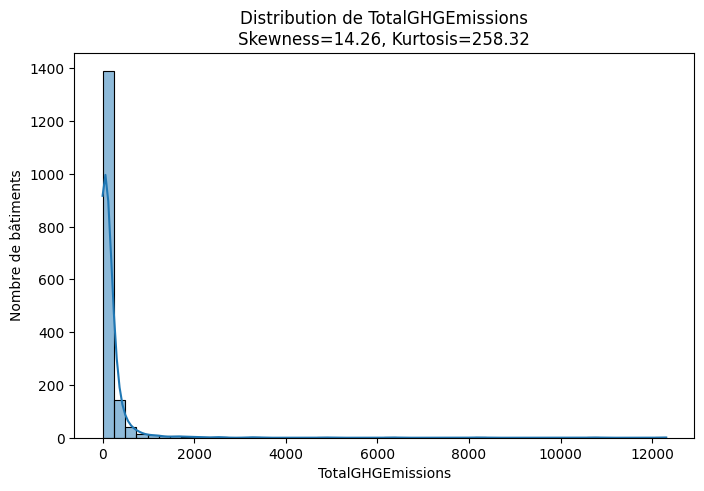

In [54]:
# Calcul skewness et kurtosis
skewness = building_consumption[TARGET].skew()
kurtosis = building_consumption[TARGET].kurt()

print(f"Skewness de {TARGET} : {skewness:.2f}")
print(f"Kurtosis de {TARGET} : {kurtosis:.2f}")

# Histogramme
plt.figure(figsize=(8, 5))
sns.histplot(building_consumption[TARGET], bins=50, kde=True)
plt.title(f"Distribution de {TARGET}\nSkewness={skewness:.2f}, Kurtosis={kurtosis:.2f}")
plt.xlabel(TARGET)
plt.ylabel("Nombre de bâtiments")
plt.show()

In [55]:
# Identification des items sans données concernant les émissions de GES, puis suppression
building_consumption[building_consumption[TARGET].isna()]
building_consumption = building_consumption[~building_consumption[TARGET].isna()]
print(
    "Nombre de bâtiments restants (après suppression des NaN) :",
    building_consumption.shape[0],
)

Nombre de bâtiments restants (après suppression des NaN) : 1625


### Identification des outliers (z-score > 3)

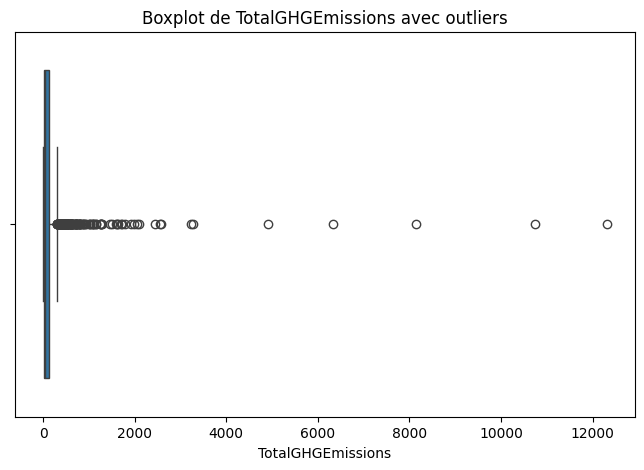

In [56]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=building_consumption[TARGET])
plt.title(f"Boxplot de {TARGET} avec outliers")
plt.show()

#### Z-score

In [57]:
# Calcul des Z-scores (en ignorant les NaN)
z_scores = stats.zscore(building_consumption[TARGET].dropna())

# Transformer en Series avec les bons index
z_scores = pd.Series(z_scores, index=building_consumption[TARGET].dropna().index)

# Sélection des outliers
outliers_z = building_consumption.loc[z_scores.abs() > 3, TARGET]

# Résumé
n_outliers = len(outliers_z)
pct_outliers = n_outliers / building_consumption.shape[0] * 100

print(f"Nombre d'outliers (Z-score) : {n_outliers}")
print("% d'outliers par rapport au dataset total : {:.2f}%".format(pct_outliers))
# Récupérer les détails complets des bâtiments outliers
outliers_details = building_consumption.loc[outliers_z.index]

# Afficher les 10 plus grands outliers avec toutes les colonnes utiles
display(outliers_details.sort_values(by=TARGET, ascending=False).head(10))

Nombre d'outliers (Z-score) : 14
% d'outliers par rapport au dataset total : 0.86%


,CouncilDistrictCode,YearBuilt,NumberofBuildings,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,TotalGHGEmissions,Office,Parking,...,NaturalGas,Electricity,PrimaryPropertyType_0,PrimaryPropertyType_1,PrimaryPropertyType_2,PrimaryPropertyType_3,PrimaryPropertyType_4,BuildingType_Nonresidential COS,BuildingType_Nonresidential WA,BuildingType_SPS-District K-12
596,3,1994,7.0,1765970,0,1765970,54.0,12307.16,0,1,...,1,1,0,1,1,0,1,0.0,0.0,0.0
164,3,2000,9.0,1158691,0,1158691,29.0,10734.57,0,1,...,1,1,0,1,1,0,1,0.0,0.0,0.0
121,4,1953,6.0,879000,0,879000,10.0,8145.52,0,0,...,1,1,0,1,1,0,1,0.0,0.0,0.0
1582,3,1920,1.0,374466,0,374466,74.0,6330.91,0,0,...,0,1,0,1,1,0,1,0.0,0.0,0.0
161,3,1990,6.0,597519,0,597519,34.0,4906.33,0,1,...,1,1,0,1,1,0,1,0.0,0.0,0.0
1034,5,1966,8.0,415632,0,415632,85.0,3278.11,0,1,...,1,1,0,1,1,0,1,0.0,0.0,0.0
1037,3,1964,1.0,591981,0,591981,60.0,3238.24,0,1,...,1,1,0,1,0,1,1,0.0,0.0,0.0
250,7,1923,1.0,542305,0,542305,45.0,2573.75,0,0,...,1,1,0,0,0,0,1,0.0,0.0,0.0
1544,3,2000,1.0,178000,0,178000,NaN,2549.47,0,0,...,0,1,1,0,0,1,0,0.0,0.0,0.0
47,7,1982,1.0,994212,146694,847518,63.0,2451.58,0,1,...,1,1,0,0,0,0,1,0.0,0.0,0.0


In [58]:
# Si besoin d'inspecter un bâtiment en particulier
building_consumption.loc[596]

CouncilDistrictCode                            3.00
YearBuilt                                   1994.00
NumberofBuildings                              7.00
PropertyGFATotal                         1765970.00
PropertyGFAParking                             0.00
PropertyGFABuilding(s)                   1765970.00
ENERGYSTARScore                               54.00
TotalGHGEmissions                          12307.16
Office                                         0.00
Parking                                        1.00
Non-Refrigerated Warehouse                     0.00
Hotel                                          0.00
K-12 School                                    0.00
Retail Store                                   0.00
Other                                          0.00
Hospital (General Medical & Surgical)          1.00
Medical Office                                 0.00
Other - Entertainment/Public Assembly          0.00
NumberofFloors_quintile                        4.00
SteamUse    

#### IQR

Nombre d'outliers (IQR) : 174
% d'outliers par rapport au dataset total : 10.71%


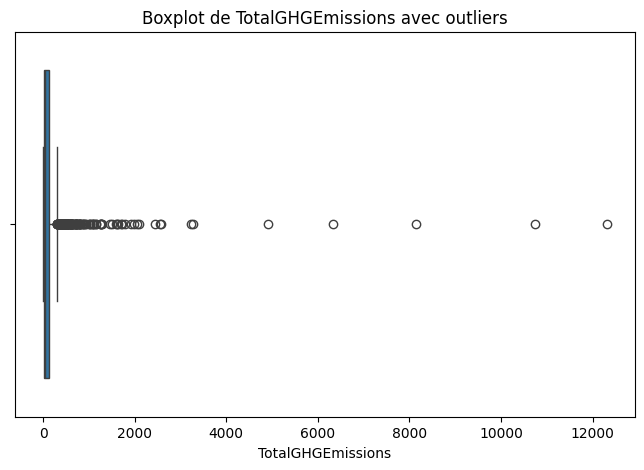

In [59]:
Q1 = building_consumption[TARGET].quantile(0.25)
Q3 = building_consumption[TARGET].quantile(0.75)
IQR = Q3 - Q1

# Bornes
borne_inf = Q1 - 1.5 * IQR
borne_sup = Q3 + 1.5 * IQR

# Outliers (hors bornes)
outliers_iqr = building_consumption.loc[
    (building_consumption[TARGET] < borne_inf)
    | (building_consumption[TARGET] > borne_sup),
    TARGET,
]

print(f"Nombre d'outliers (IQR) : {len(outliers_iqr)}")
print(
    "% d'outliers par rapport au dataset total : {:.2f}%".format(
        len(outliers_iqr) / building_consumption.shape[0] * 100
    )
)
outliers_iqr.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.boxplot(x=building_consumption[TARGET])
plt.title(f"Boxplot de {TARGET} avec outliers")
plt.show()

### Nettoyage des valeurs manquantes

In [60]:
# Vérification des valeurs manquantes
print("Valeurs manquantes par colonne :")
missing_values = building_consumption.isnull().sum()
missing_features = missing_values[missing_values > 0]
print(missing_features)

if len(missing_features) > 0:
    print(f"\nNombre total de valeurs manquantes : {missing_values.sum()}")
    print(f"Pourcentage de valeurs manquantes : {(missing_values.sum() / building_consumption.size) * 100:.2f}%")
else:
    print("Aucune valeur manquante détectée.")
    
print(f"\nShape avant nettoyage : {building_consumption.shape}")

Valeurs manquantes par colonne :
ENERGYSTARScore    547
dtype: int64

Nombre total de valeurs manquantes : 547
Pourcentage de valeurs manquantes : 1.12%

Shape avant nettoyage : (1625, 30)


In [64]:
# Pour ENERGYSTARScore : pas besoin d'effectuer une imputation par la médiane (score énergétique) car le score médian dans la définition est de 50

building_consumption.loc[
    building_consumption["ENERGYSTARScore"].isna(), "ENERGYSTARScore"
] = 50


# Vérification finale
total_missing_after = building_consumption.isnull().sum().sum()
print(f"\nNombre total de valeurs manquantes après nettoyage : {total_missing_after}")
print(f"Shape après nettoyage : {building_consumption.shape}")


Nombre total de valeurs manquantes après nettoyage : 0
Shape après nettoyage : (1625, 30)


In [65]:
### Dataset final nettoyé
building_consumption.to_csv(
    "../assets/building_consumption_cleaned.csv", index=False
)
print(f"Dataset sauvegardé avec {building_consumption.shape[0]} lignes et {building_consumption.shape[1]} colonnes")
print("Aucune valeur manquante restante")

Dataset sauvegardé avec 1625 lignes et 30 colonnes
Aucune valeur manquante restante
